In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings('ignore')


sns.set(style='white', context='notebook', palette='deep')
%matplotlib inline

In [2]:
def visualize_feature_importance(model, X_train):
    # barplotに持ち込むためのDFを生成
    df = pd.DataFrame()
    df['feature_name'] = X_train.columns
    df['feature_importance'] = model.feature_importances_

    # 降順のほうが見やすいのでソート
    df.sort_values(by='feature_importance', ascending=False, inplace=True)

    # 重要度0はノイズに思えるので除外している
    df = df[df['feature_importance'] > 0]

    sns.barplot(x='feature_importance',
                y='feature_name',
                data=df)

    plt.xlim(0, 1.0)

In [3]:
train = pd.read_csv('../input_data/train.csv')
test = pd.read_csv('../input_data/test.csv')

## データ整形

In [4]:
y_train = train[['Survived']]

X_train = train.drop(columns=['PassengerId', 'Survived'])
X_train = X_train.drop(columns=['Name'])
X_train = X_train.drop(columns=['Ticket'])
X_train = X_train.drop(columns=['Cabin'])


# 雑に欠損埋める
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())

# 全部ダミー変数
X_train = pd.get_dummies(X_train)

# 現状を確認
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


## 決定木でやる

In [5]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini',
                                    splitter='best',
                                    max_depth=10)

tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [6]:
tree_model.score(X_train, y_train)

0.9214365881032548

In [7]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, tree_model.predict_proba(X_train)[:, 1])

0.9685472789441727

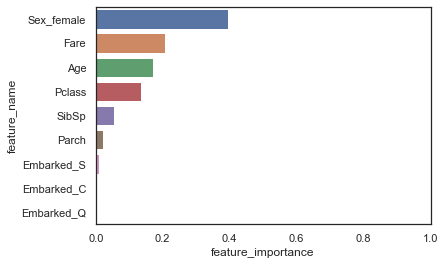

In [8]:
visualize_feature_importance(tree_model, X_train)

In [9]:
# testデータの処理
X_test = test.drop(columns=['PassengerId'])
X_test = X_test.drop(columns=['Name'])
X_test = X_test.drop(columns=['Ticket'])
X_test = X_test.drop(columns=['Cabin'])

# 雑に欠損埋める
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].mean())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].mean())


# 全部ダミー変数
X_test = pd.get_dummies(X_test)

X_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0,1,0,1,0
1,3,47.0,1,0,7.0000,1,0,0,0,1
2,2,62.0,0,0,9.6875,0,1,0,1,0
3,3,27.0,0,0,8.6625,0,1,0,0,1
4,3,22.0,1,1,12.2875,1,0,0,0,1


In [10]:
# submit_dataつくり
submit_data = test[['PassengerId']].copy()
submit_data['Survived'] = tree_model.predict(X_test)

In [16]:
# スコア: 0.73684
submit_data.to_csv('base_line_model.csv', index=False)